# 0. Install and Import dependencies

**Important note: tensorflow==1.15.0 works only with Python 3.7 and below**

In [ ]:
%pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym==0.19.0 finta protobuf==3.20.*

In [33]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C, DQN, PPO2

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# 1. Load  Data 

Example data can be loaded from this website

https://www.marketwatch.com/tools/markets/stocks

In [34]:
df = pd.read_csv('data/Google_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [35]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [36]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [37]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [38]:
env = gym.make('stocks-v0', df=df, frame_bound=(80,250), window_size=12)

# 2. Build Environment

Here we will build and environment and plot trading result of an agent performing random actions. 

Since both random and some deep reinforcement learning policy will have probabilistic nature, we will run 10 iterations to evaluate a better mean profit and reward.

In [39]:
def evaluate_random(env):
    reward_list = []
    profit_list = []

    for i in range(10):
        state = env.reset()
        while True: 
            action = env.action_space.sample()
            n_state, reward, done, info = env.step(action)
            if done: 
                print("info", info)
                reward_list.append(env._total_reward)
                profit_list.append(env._total_profit)
                break
        
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()

    random_mean_reward=np.array(reward_list).mean()
    print(f'Mean return per episode is {random_mean_reward}')

    random_mean_profit=np.array(profit_list).mean()
    print(f'Mean profit is {random_mean_profit}')

info {'total_reward': 10.725752000000199, 'total_profit': 0.5026705099665495, 'position': 1}
info {'total_reward': -43.22827399999994, 'total_profit': 0.4353229314947678, 'position': 1}
info {'total_reward': -27.90301400000004, 'total_profit': 0.46065555190030166, 'position': 1}
info {'total_reward': -27.17715200000015, 'total_profit': 0.47793616369871134, 'position': 0}
info {'total_reward': 5.03503400000028, 'total_profit': 0.5683360992308962, 'position': 0}
info {'total_reward': -14.904937000000047, 'total_profit': 0.48867696335366023, 'position': 1}
info {'total_reward': 27.56751799999992, 'total_profit': 0.5929739806072752, 'position': 0}
info {'total_reward': 12.922864999999803, 'total_profit': 0.533230894238334, 'position': 0}
info {'total_reward': 4.5795880000002, 'total_profit': 0.5250120641982328, 'position': 1}
info {'total_reward': -24.719876, 'total_profit': 0.4958582016231878, 'position': 0}


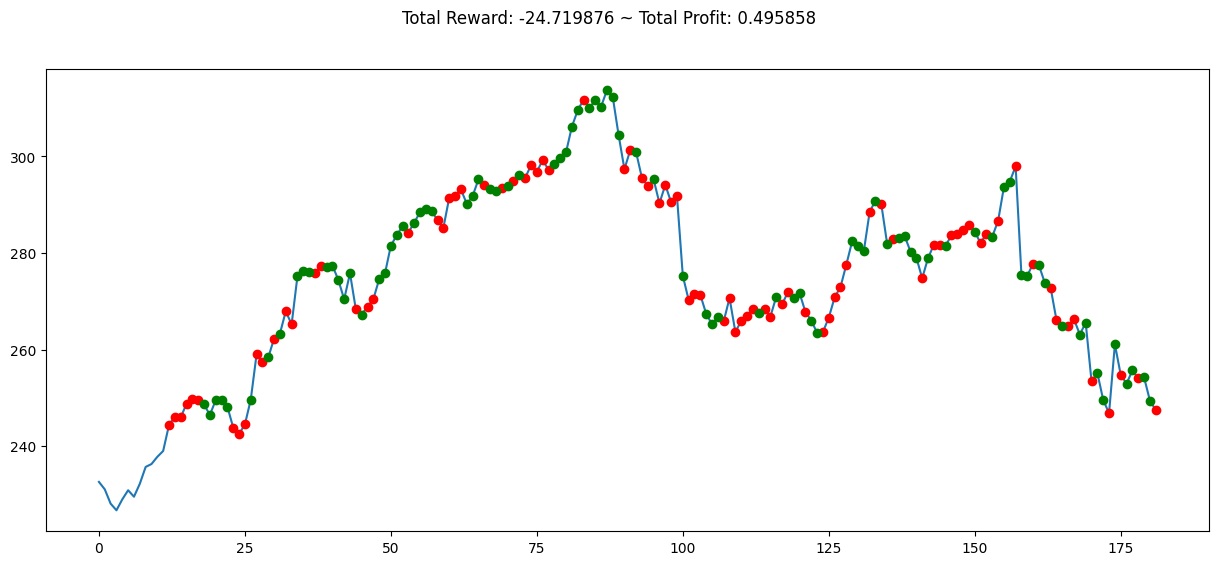

Mean return per episode is -7.710249599999978
Mean profit is 0.5080673360311916


In [40]:
evaluate_random(env)

This is the graph of **the last iteration** of random agent evaluation. 

We have 2 positions - Long (Green) and Short (Red). 

**Also, we need to Draw a MDP-graph of an environment** Reward function will be explained in the paper and presentation.

# 3. Basic model training and evaluation

**Training is done in train_script.py**

**Let's have A2C model with MlpLSTM policy as a baseline.**

Model was trained on Intel® Core™ i7-10700F with 8-cores.

In [41]:
def evaluate(env, model):
    reward_list = []
    profit_list = []

    for i in range(10):
        obs = env.reset()
        while True: 
            obs = obs[np.newaxis, ...]
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            if done:
                print("info", info)
                reward_list.append(env._total_reward)
                profit_list.append(env._total_profit)
                break

    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()

    random_mean_reward=np.array(reward_list).mean()
    print(f'Mean return per episode is {random_mean_reward}')

    random_mean_profit=np.array(profit_list).mean()
    print(f'Mean profit per episode is {random_mean_profit}')

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': -5.860792999999802, 'total_profit': 0.499963623758058, 'position': 1}
info {'total_reward': -24.474684999999937, 'total_profit': 0.515592229485384, 'position': 0}
info {'total_reward': 15.25022699999974, 'total_profit': 0.5074801124892009, 'position': 1}
info {'total_reward': 44.32934699999993, 'total_profit': 0.6644342016945645, 'position': 1}
info {'total_reward': -24.18421499999991, 'total_profit': 0.44627284150076935, 'position': 1}
info {'total_reward': 33.183273999999955, 'total_profit': 0.565596177355713, 'position': 1}
info {'total_reward': -7.252367000000135, 'total_profit': 0.5285838712086571, 'position': 0}
info {'total_reward': -2.7076550000000736, 'total_profit': 0.5483132843252877, 'position': 0}
info {'total_reward': -56.051073000000144, 'total_profit': 0.4300783497360304, 'position': 0}
info {'total_reward': 16.65143400000008, 'total_profit': 0.50

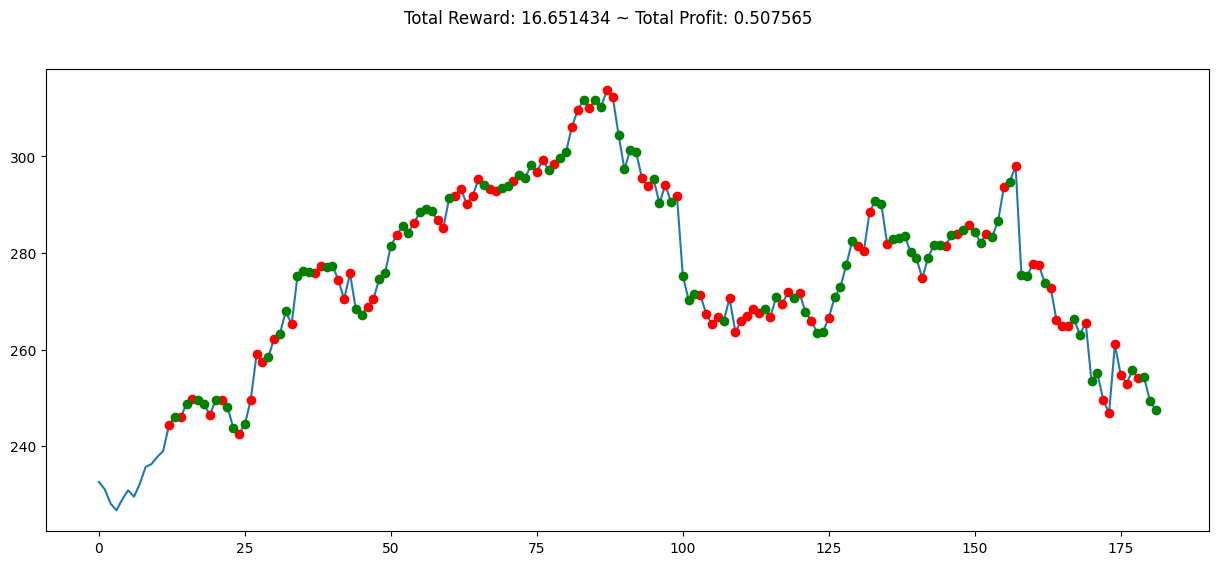

Mean return per episode is -1.11165060000003
Mean profit per episode is 0.5213879387453995


In [42]:
from gym_anytrading.envs import StocksEnv

model = A2C.load("models/A2C_LSTM_Basic.zip")

env = StocksEnv(df=df, frame_bound=(80,250), window_size=12)

evaluate(env, model)

Reward and profit are **almost identical to random agent**. Let's try to add custom indicators!

# 4. Add Custom Indicators

## 4.1.1. Import New Dependencies

In [43]:
# Is needed to calculate custom indicators
from finta import TA

## 4.1.2. Fix Volume Column

In [44]:
df['Volume'] = df['Volume'].apply(lambda x: float(f"{x}".replace(",", "")))

In [45]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

## 4.1.3. Calculate SMA, RSI and OBV

In [46]:
# SMA - Simple moving average
# RSI - Relative Strenght Index
# OBV - On Balance Volume.

df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [47]:
df.head(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700.0,0.000000,0.000000,0.0
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700.0,0.000000,100.000000,6202700.0
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500.0,0.000000,100.000000,12265200.0
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200.0,0.000000,100.000000,17597400.0
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100.0,0.000000,100.000000,22888500.0
2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100.0,0.000000,100.000000,29526600.0
2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900.0,0.000000,100.000000,34768500.0
2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500.0,0.000000,100.000000,41827000.0
2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900.0,0.000000,100.000000,49095900.0


## 4.1.4. Create New Environments

In [48]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [49]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [50]:
pd.DataFrame(env2.signal_features)

,0,1,2,3,4
0,196.196198,3433700.0,0.000000,0.000000,0.0
1,195.195190,6202700.0,0.000000,100.000000,6202700.0
2,202.607605,6062500.0,0.000000,100.000000,12265200.0
3,202.507507,5332200.0,0.000000,100.000000,17597400.0
4,205.555557,5291100.0,0.000000,100.000000,22888500.0
5,209.474472,6638100.0,0.000000,100.000000,29526600.0
6,211.911911,5241900.0,0.000000,100.000000,34768500.0
7,212.212219,7058500.0,0.000000,100.000000,41827000.0
8,217.467468,7268900.0,0.000000,100.000000,49095900.0
9,219.949951,7354200.0,0.000000,100.000000,56450100.0


In [51]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700.0,0.0,0.0,0.0
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700.0,0.0,100.0,6202700.0
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500.0,0.0,100.0,12265200.0
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200.0,0.0,100.0,17597400.0
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100.0,0.0,100.0,22888500.0


In [52]:
import os

# Saving file, if it's now saved
if not os.path.exists('data/Google_Custom_data.csv'):
    df.to_csv('data/Google_data_3_extra_features.csv')

# 5. Evaluation of extended model

**Training is done in train_script.py**

During training and evaluation you might face following error: https://stackoverflow.com/questions/71449872/stable-baselines-module-error-gym-logger-has-no-attribute-min-level

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': 40.730817000000116, 'total_profit': 0.7023566495681862, 'position': 1}
info {'total_reward': 41.24128700000017, 'total_profit': 0.7247334703249582, 'position': 1}
info {'total_reward': 28.198272000000145, 'total_profit': 0.7355820093048326, 'position': 1}
info {'total_reward': 30.0601190000001, 'total_profit': 0.7286522314546885, 'position': 1}
info {'total_reward': 26.82685800000013, 'total_profit': 0.7550085942206372, 'position': 1}
info {'total_reward': 33.60365100000007, 'total_profit': 0.7151152571269725, 'position': 1}
info {'total_reward': 16.196227000000135, 'total_profit': 0.7139894898404024, 'position': 1}
info {'total_reward': 37.48751800000011, 'total_profit': 0.7156013323225385, 'position': 1}
info {'total_reward': 28.583662000000118, 'total_profit': 0.7106123760368853, 'position': 1}
info {'total_reward': 38.37846200000013, 'total_profit': 0.7398331

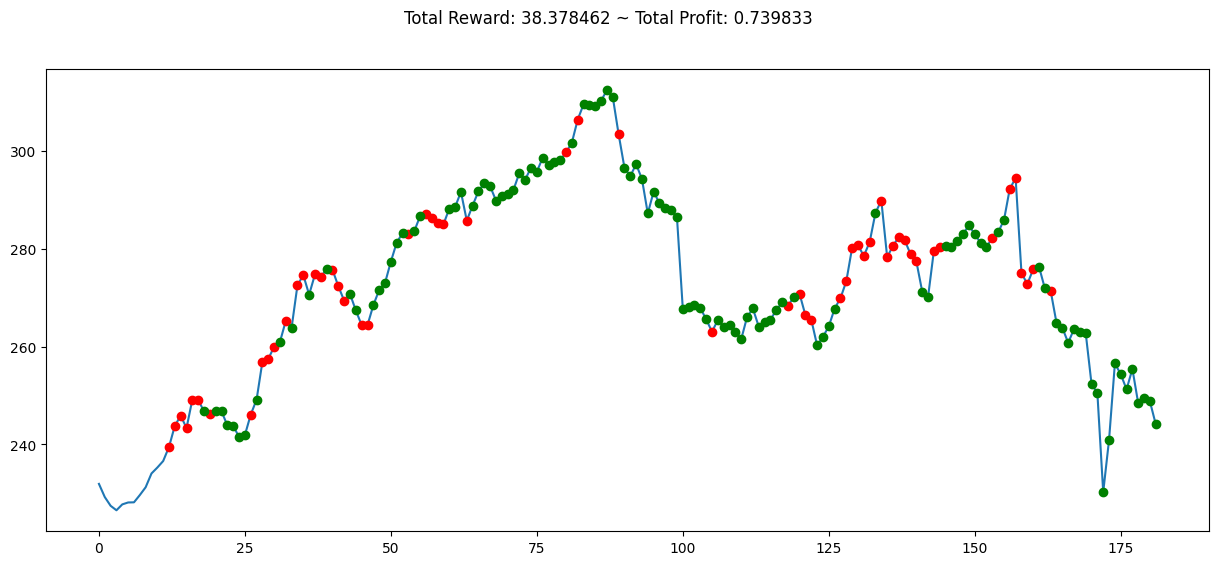

Mean return per episode is 32.130687300000126
Mean profit per episode is 0.7241484583116251


In [53]:
# A2C_LSTM

df = pd.read_csv('data/Google_data_3_extra_features.csv')

model = A2C.load("models/A2C_LSTM_Custom.zip")

env = MyCustomEnv(df=df, frame_bound=(80, 250), window_size=12)

evaluate(env, model)


As we can see, already, results in reward and profit are better in comparising with random agent. Let's try to improve the results by adding a couple of more indicators!

# 6. Adding more indicators and comparing training time

In [54]:
# ADX - Average Directional Index
# STOCH - Stochastic Oscillator

df2 = df

df2['ADX'] = TA.ADX(df2)
df2['STOCH'] = TA.STOCH(df2)
df2.fillna(0, inplace=True)

In [55]:
df2.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV,ADX,STOCH
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700.0,0.000000,0.000000,0.0,0.000000,0.000000
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700.0,0.000000,100.000000,6202700.0,0.000000,0.000000
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500.0,0.000000,100.000000,12265200.0,0.000000,0.000000
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200.0,0.000000,100.000000,17597400.0,0.000000,0.000000
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100.0,0.000000,100.000000,22888500.0,0.000000,0.000000
5,2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100.0,0.000000,100.000000,29526600.0,0.000000,0.000000
6,2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900.0,0.000000,100.000000,34768500.0,0.000000,0.000000
7,2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500.0,0.000000,100.000000,41827000.0,0.000000,0.000000
8,2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900.0,0.000000,100.000000,49095900.0,0.000000,0.000000
9,2009-06-05,222.757751,223.893890,219.949951,222.382385,222.382385,7354200.0,0.000000,100.000000,56450100.0,0.000000,0.000000


In [56]:
# Saving file, if it's now saved

if not os.path.exists('data/Google_Extended_Custom_data.csv'):
    df.to_csv('data/Google_data_5_extra_features.csv')

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': 44.27926499999998, 'total_profit': 0.8433111143569765, 'position': 1}
info {'total_reward': 48.418395000000004, 'total_profit': 0.8558651540059307, 'position': 1}
info {'total_reward': 47.23223799999997, 'total_profit': 0.8519917125188133, 'position': 1}
info {'total_reward': 46.946928999999926, 'total_profit': 0.838497426220435, 'position': 1}
info {'total_reward': 44.44442699999993, 'total_profit': 0.8189863651435567, 'position': 1}
info {'total_reward': 38.63362099999998, 'total_profit': 0.8118932277191194, 'position': 1}
info {'total_reward': 50.11508299999994, 'total_profit': 0.86198187342738, 'position': 1}
info {'total_reward': 41.64161599999997, 'total_profit': 0.8094104137552087, 'position': 1}
info {'total_reward': 54.14913900000002, 'total_profit': 0.874596509821099, 'position': 1}
info {'total_reward': 41.11610399999998, 'total_profit': 0.818906448221

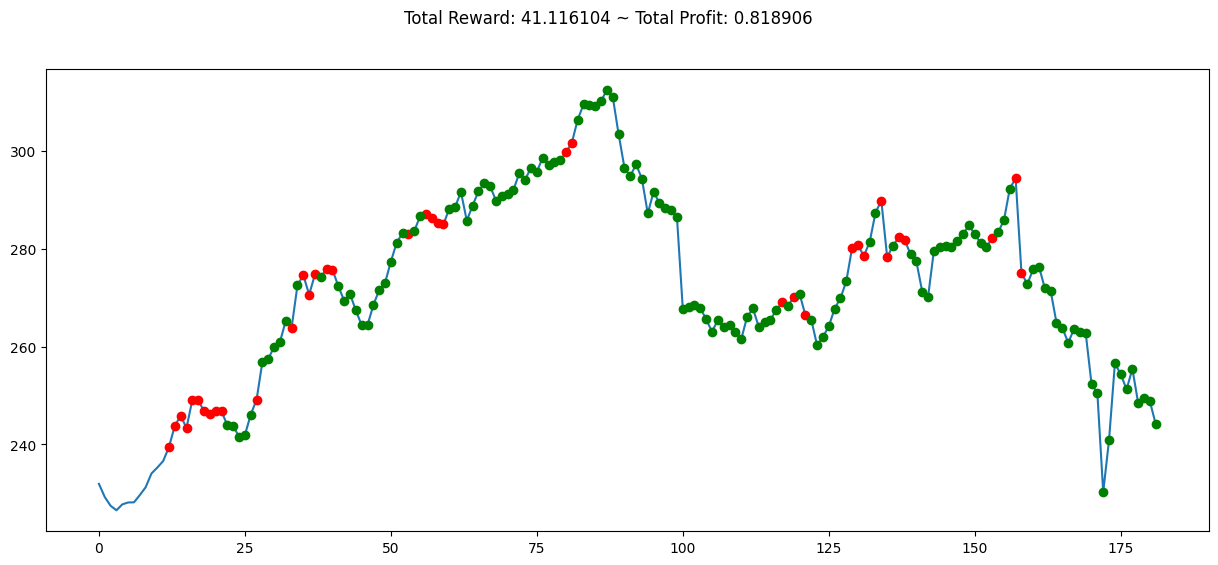

Mean return per episode is 45.69768169999996
Mean profit per episode is 0.838544024518986


In [57]:
# A2C_LSTM

model = A2C.load("models/A2C_LSTM_Extended_Custom.zip")

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA', 'RSI', 'OBV', 'ADX', 'STOCH']].to_numpy()[
        start:end]
    return prices, signal_features


class ExtendedCustomEnv(StocksEnv):
    _process_data = add_signals



env = ExtendedCustomEnv(df=df2, frame_bound=(80,250), window_size=12)

evaluate(env, model)

Results became better. Surprisingly, training time is almost the same. So we can train model on more dimensional data in the same time. But, maybe, time difference will be more sufficient on worse hardware.

![image](Reward+training_time.png)

# 7. Trying out other algorythms and models.

### A2C_Mlp

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': 23.90390200000013, 'total_profit': 0.646878783246913, 'position': 1}
info {'total_reward': 11.056017000000082, 'total_profit': 0.6080655196326207, 'position': 1}
info {'total_reward': 4.489459000000011, 'total_profit': 0.5866766167839428, 'position': 1}
info {'total_reward': 52.872863000000024, 'total_profit': 0.7509772482503962, 'position': 1}
info {'total_reward': -24.419368999999847, 'total_profit': 0.5530250673855129, 'position': 1}
info {'total_reward': 16.541551000000027, 'total_profit': 0.6490577568024758, 'position': 1}
info {'total_reward': 17.047032000000115, 'total_profit': 0.6703569626437029, 'position': 1}
info {'total_reward': -30.540583999999996, 'total_profit': 0.5184048720962876, 'position': 1}
info {'total_reward': -6.49145399999972, 'total_profit': 0.599669677113905, 'position': 1}
info {'total_reward': 21.82182700000004, 'total_profit': 0.6570

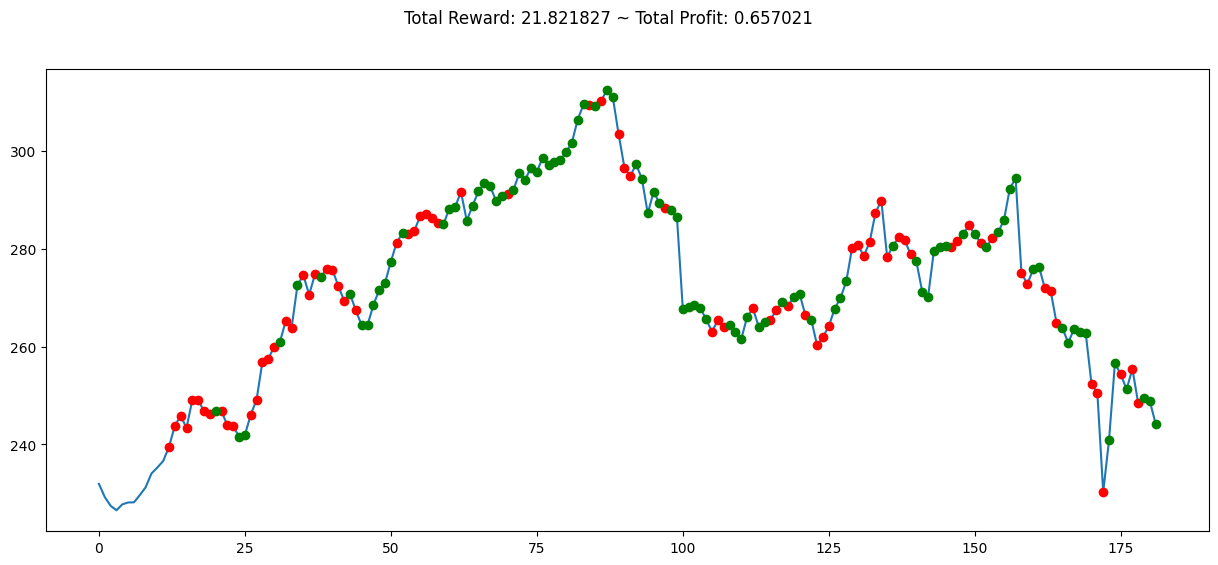

Mean return per episode is 8.628124400000086
Mean profit per episode is 0.6240133256569337


In [58]:
model = A2C.load("models/A2C_Mlp.zip")
evaluate(env, model)

### DQN_Mlp

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_profit': 0.7214521763017729, 'position': 0}
info {'total_reward': -11.876860000000136, 'total_p

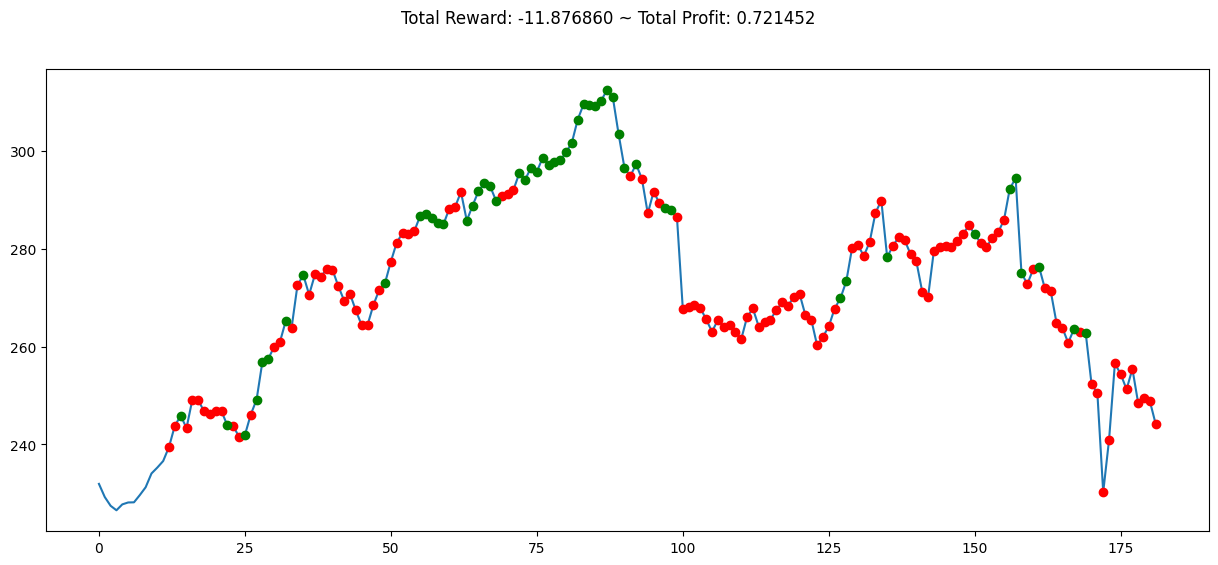

Mean return per episode is -11.876860000000136
Mean profit per episode is 0.7214521763017728


In [59]:
model = DQN.load("models/DQN_Mlp.zip")
evaluate(env, model)

### Ln_DQN_Mlp

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_profit': 0.7324662607586432, 'position': 1}
info {'total_reward': -21.771804999999915, 'total_p

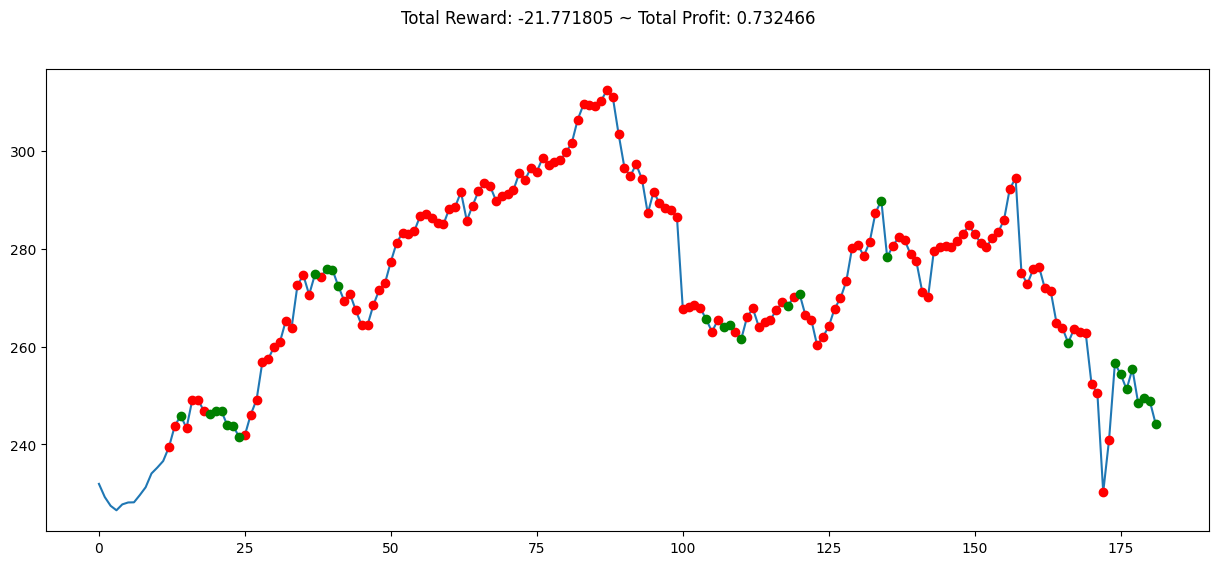

Mean return per episode is -21.771804999999915
Mean profit per episode is 0.7324662607586433


In [60]:
model = DQN.load("models/Ln_DQN_Mlp.zip")
evaluate(env, model)

### PPO2_Mlp

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': 26.866787000000244, 'total_profit': 0.6011014909839671, 'position': 0}
info {'total_reward': 23.793745000000087, 'total_profit': 0.6292579871671214, 'position': 0}
info {'total_reward': 51.70666200000019, 'total_profit': 0.711471584674045, 'position': 0}
info {'total_reward': 21.436444000000193, 'total_profit': 0.6364923084997425, 'position': 0}
info {'total_reward': 25.395323000000047, 'total_profit': 0.6625267954707247, 'position': 0}
info {'total_reward': 40.21009700000005, 'total_profit': 0.7226293606146459, 'position': 0}
info {'total_reward': 43.29830700000011, 'total_profit': 0.7107352794148769, 'position': 0}
info {'total_reward': 32.82279600000007, 'total_profit': 0.6615419546160607, 'position': 0}
info {'total_reward': 38.8788270000002, 'total_profit': 0.655526248357302, 'position': 0}
info {'total_reward': 36.11598000000018, 'total_profit': 0.716152916

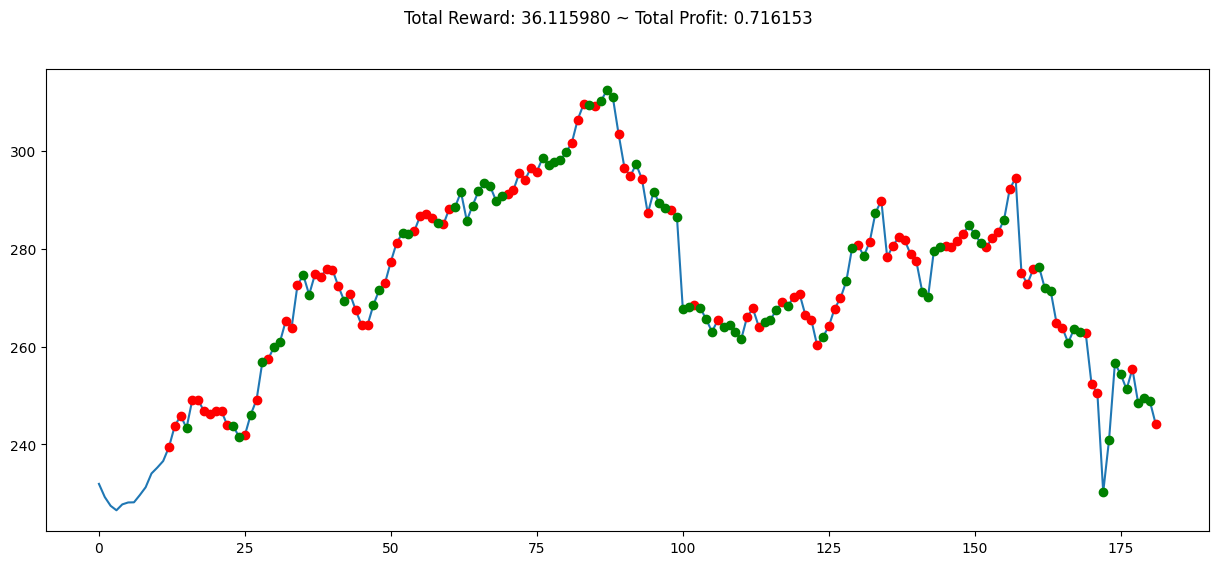

Mean return per episode is 34.05249680000013
Mean profit per episode is 0.6707435926144772


In [61]:
model = PPO2.load("models/PPO2_Mlp.zip")
evaluate(env, model)

### PPO2_LSTM

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info {'total_reward': 9.67965499999994, 'total_profit': 0.7390450604037467, 'position': 1}
info {'total_reward': 27.93792600000009, 'total_profit': 0.7672915667054215, 'position': 1}
info {'total_reward': 1.2462450000000729, 'total_profit': 0.7529853701711234, 'position': 1}
info {'total_reward': 10.920868000000013, 'total_profit': 0.7681151833887787, 'position': 1}
info {'total_reward': 5.345306000000022, 'total_profit': 0.7298032214435473, 'position': 1}
info {'total_reward': 3.248199999999912, 'total_profit': 0.7233796065807261, 'position': 1}
info {'total_reward': 9.58459400000001, 'total_profit': 0.7631326607844893, 'position': 1}
info {'total_reward': 9.184173000000072, 'total_profit': 0.7283654570159823, 'position': 1}
info {'total_reward': 33.328338000000116, 'total_profit': 0.832763313698758, 'position': 1}
info {'total_reward': 6.196257000000031, 'total_profit': 0.7448696664

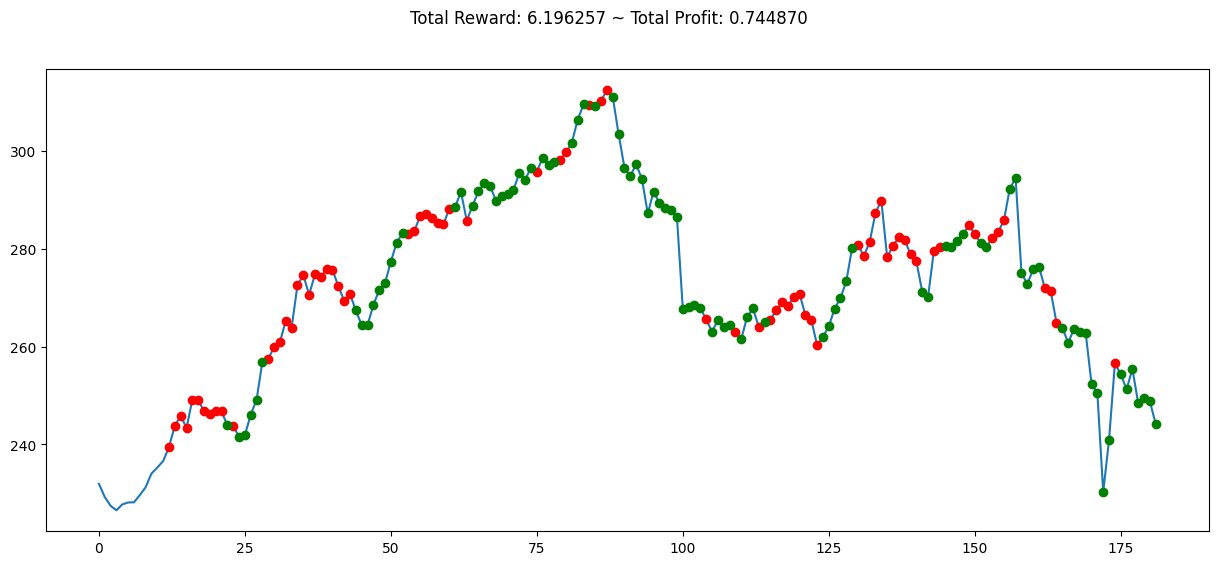

Mean return per episode is 11.667156200000028
Mean profit per episode is 0.7549751106638177


In [62]:
model = PPO2.load("models/PPO2_Mlp_LSTM.zip")
evaluate(env, model)

None of the models evaluated above have reached the results of our baseline - **A2C_LSTM**.